In [1]:
# all hyperparameters taken from https://www.sciencedirect.com/science/article/pii/S0165027020303095

import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
data = pd.read_pickle("data/epoched_train.pkl")
data

,patient_id,start_time,event_type,C3,Cz,C4,EOG:ch01,EOG:ch02,EOG:ch03
0,B0101T,223556.0,0,"[-3.6285954070344086, -2.337682154573892, -3.6...","[-2.920576791027695, -2.47501335164416, -2.548...","[5.502403295948728, 6.485084306095978, 6.68955...","[7.354848554207674, 4.699778744182498, 8.39246...","[5.676356145571068, 10.2235446707866, 16.08300...","[9.857328145265887, 4.303044174868391, 15.5336..."
1,B0101T,232996.0,1,"[2.9480430304417484, -0.05493247882810711, 0.3...","[4.437323567559321, 2.4872205691615163, 0.9674...","[1.3855191882200348, -0.4699778744182498, 0.44...","[-18.127718013275352, 18.188754100862134, -5.8...","[-14.373998626688028, 21.484702830548557, -6.2...","[-11.9325551232166, 20.202944991226055, -9.613..."
2,B0101T,251268.0,0,"[-0.2380407415884641, -2.0721751735713743, -2....","[2.825970855268177, 3.308155947203784, 1.83718...","[-0.9155413138017852, -0.5645838101777675, -2....","[-8.331425955596247, -15.7778286411841, -1.922...","[-1.9226367589837492, -9.552147707331956, -6.6...","[-8.453498130769818, -15.228503852903028, -7.1..."
3,B0101T,259416.0,1,"[-0.5554283970397498, -2.926680399786373, -4.9...","[5.743495841916532, 4.785229266803998, 3.40581...","[0.9155413138017852, 1.541161211566339, 1.0284...","[6.6224155031662475, 3.1128404669260696, 11.74...","[-1.6174563210498203, -2.349889372091249, 9.00...","[-2.2278171969176768, 2.349889372091249, 12.90..."
4,B0101T,294924.0,1,"[-2.8961623559929808, -2.352941176470588, -1.7...","[2.8442816815442127, 2.7557793545433737, 2.075...","[-0.8331425955596247, -0.32349126420996416, 0....","[7.2938124666208894, -2.655069810025177, 7.110...","[7.934691386282138, 0.18310826276035705, 12.93...","[14.740215152208743, 6.3172350652323175, 15.47..."
...,...,...,...,...,...,...,...,...,...
3675,B0903T,1790936.0,0,"[4.151404151404152, 3.736263736263736, 3.22344...","[2.7594627594627594, 2.9792429792429798, 2.686...","[4.493284493284493, 3.345543345543345, 4.39560...","[-4.395604395604395, 0.9768009768009768, -3.41...","[14.652014652014651, 7.814407814407812, 5.3724...","[1.4652014652014649, 4.884004884004884, -5.372..."
3676,B0903T,1800012.0,1,"[1.4163614163614164, 0.21978021978021972, -0.0...","[2.686202686202685, 2.1978021978021984, 1.7338...","[0.31746031746031744, -0.46398046398046394, 0....","[7.814407814407812, 5.86080586080586, 1.465201...","[9.27960927960928, 10.256410256410255, 1.95360...","[11.72161172161172, 14.652014652014651, 4.3956..."
3677,B0903T,1810236.0,1,"[1.8559218559218558, 0.5860805860805861, -0.46...","[0.2686202686202686, 0.9768009768009768, 0.610...","[1.0256410256410255, 0.7081807081807082, 2.222...","[-17.094017094017097, 7.326007326007326, 0.488...","[-15.140415140415142, 20.51282051282051, -6.34...","[-14.163614163614163, 16.117216117216113, 1.46..."
3678,B0903T,1820720.0,0,"[0.2686202686202686, 0.21978021978021972, -0.0...","[2.3443223443223444, 2.148962148962149, 3.6385...","[3.736263736263736, 4.615384615384613, 4.20024...","[4.395604395604395, 1.4652014652014649, 19.536...","[12.210012210012207, -1.953601953601953, 11.72...","[4.884004884004884, -3.418803418803418, 17.582..."


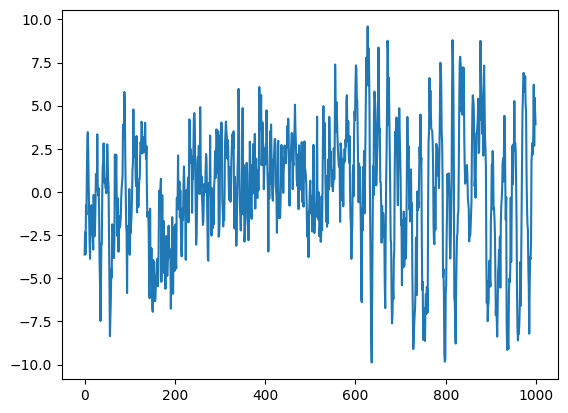

In [3]:
# format: left[event_number][channel_number][index][time, value]

# Let's extract a single channel from a single event
x = data.iloc[0]['C3']

plt.plot(x)

/home/nathan/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Filtered Data')

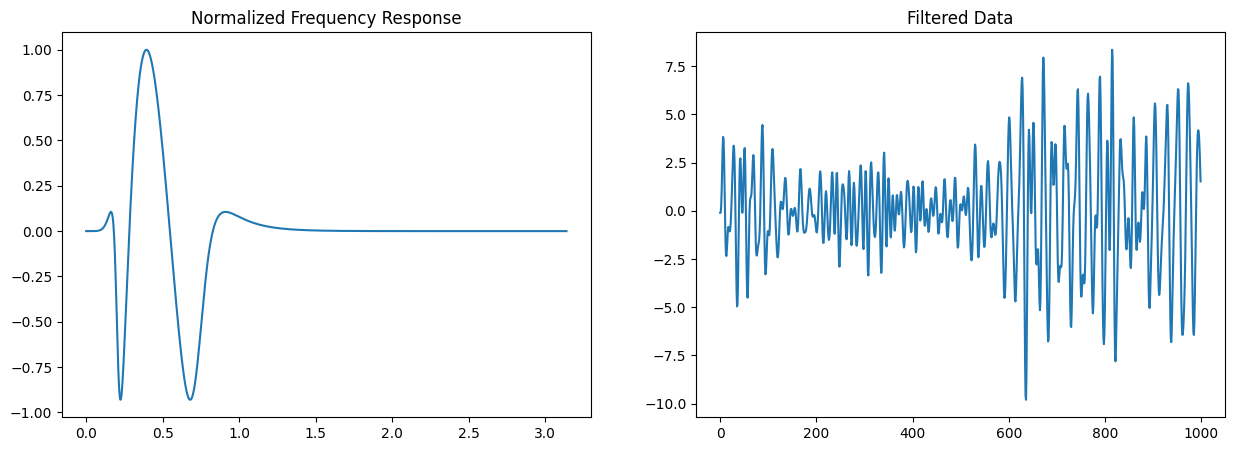

In [4]:
# Butterworth Bandpass Filter
# Taken from https://stackoverflow.com/a/48677312

from scipy.signal import butter, freqz, sosfiltfilt, sosfreqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 250
lowcut = 8
highcut = 30

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfiltfilt(sos, data)
        return y

sos = butter_bandpass(lowcut, highcut, fs)
w, h = sosfreqz(sos, worN=2000)

y = butter_bandpass_filter(x, lowcut, highcut, fs)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].plot(w, h)
ax[0].set_title("Normalized Frequency Response")

ax[1].plot(y)
ax[1].set_title("Filtered Data")

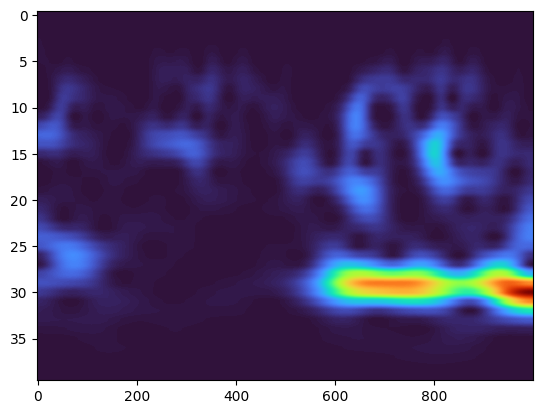

In [5]:
# Continuous Wavelet Transform
# Taken from https://dsp.stackexchange.com/a/87760

from ssqueezepy import Wavelet, cwt
from ssqueezepy.utils import make_scales, cwt_scalebounds
from ssqueezepy.visuals import plot, imshow

wavelet = Wavelet(('gmw', {'gamma': 3, 'beta': 60}))

# configure
def generate_cwt(data):
    signal_length = len(data)

    # make scales
    min_scale, max_scale = cwt_scalebounds(wavelet, signal_length)
    scales = make_scales(signal_length, scaletype='log-piecewise', nv=16, # log-piecewise and 16 voices recommended by library
                         min_scale=min_scale, max_scale=max_scale, wavelet=wavelet)

    # make filterbank
    fbank = wavelet(scale=scales)

    # take CWT
    wx, _ = cwt(data, wavelet, scales=scales)

    # square it
    wx = wx ** 2

    # visualize
    # plot(fbank.T, show=1, title="CWT filterbank")
    # imshow(wx, title="CWT(x)**2", abs=True)
    
    return np.abs(wx)

wx = generate_cwt(y)[30:70]
imshow(wx, abs=True)

3680it [03:15, 18.86it/s]


0


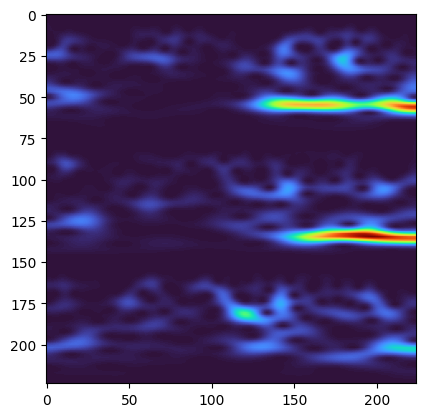

In [6]:
import cv2

channels = ['C3', 'Cz', 'C4']

fs = 250
lowcut = 8
highcut = 30

images = []
labels = []

start = 30
end = 70

dim = (224, 224)

for _, row in tqdm(data.iterrows()):
    img = np.array([])

    for channel in channels:
        x = row[channel]

        filtered = butter_bandpass_filter(x, lowcut, highcut, fs)
        wt = generate_cwt(filtered)[start:end]

        if img.size:
            img = np.vstack((img, wt))
        else:
            img = wt

    img = cv2.resize(img, dim)
    cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
            
    images.append(img)
    labels.append(row['event_type'])
    
plt.imshow(images[0], cmap='turbo')
print(labels[0])

In [7]:
def get_mpl_colormap(cmap_name):
    cmap = plt.get_cmap(cmap_name)

    # Initialize the matplotlib color map
    sm = plt.cm.ScalarMappable(cmap=cmap)

    # Obtain linear color range
    color_range = sm.to_rgba(np.linspace(0, 1, 256), bytes=True)[:,2::-1]

    return color_range.reshape(256, 1, 3)

In [8]:
indices = np.arange(len(images))
np.random.shuffle(indices)

In [9]:
import cv2
import time

left_counter = 0
right_counter = 0

test_size = int(.2*len(images) / 2)

for i in tqdm(indices):
    img = images[i]
    label = labels[i]
    
    img = cv2.applyColorMap(np.uint8(img), get_mpl_colormap('turbo'))
    
    # left
    if label == 0:
        # test
        if left_counter < test_size:
            cv2.imwrite(f"./img_data/test/left/{time.time()}.jpg", img)
        # train
        else:
            cv2.imwrite(f"./img_data/train/left/{time.time()}.jpg", img)
            
        cv2.imwrite(f"./gan_data/left/data/{time.time()}.jpg", img)
        left_counter += 1
            
    # right
    else:
        # test
        if right_counter < test_size:
            cv2.imwrite(f"./img_data/test/right/{time.time()}.jpg", img)
        # train
        else:
            cv2.imwrite(f"./img_data/train/right/{time.time()}.jpg", img)
    
        cv2.imwrite(f"./gan_data/right/data/{time.time()}.jpg", img)
        right_counter += 1

100%|██████████████████████████████████████| 3680/3680 [00:09<00:00, 385.31it/s]
